# EECS 491 Artificial Intelligence - Probabilistic Graphical Models
## Project: Sign Language Recognition System

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)



##  Dataset

I created a data class as the `AslDb` class.  This class creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  I used those to create models later.

To start, let's set up the initial database and select an example set of features for the training set.  

In [1]:
import os

import numpy as np
import pandas as pd


class AslDb(object):
    def __init__(self,
                 hands_fn=os.path.join('data', 'hands_condensed.csv'),
                 speakers_fn=os.path.join('data', 'speaker.csv'),
                 ):
        self.df = pd.read_csv(hands_fn).merge(pd.read_csv(speakers_fn),on='video')
        self.df.set_index(['video','frame'], inplace=True)

    def build_training(self, feature_list, csvfilename =os.path.join('data', 'train_words.csv')):
        return WordsData(self, csvfilename, feature_list)

    def build_test(self, feature_method, csvfile=os.path.join('data', 'test_words.csv')):
        return SinglesData(self, csvfile, feature_method)


class WordsData(object):
    """ class provides loading and getters for ASL data suitable for use with hmmlearn library

    """

    def __init__(self, asl:AslDb, csvfile:str, feature_list:list):
        """ loads training data sequences suitable for use with hmmlearn library based on feature_method chosen

        :param asl: ASLdata object
        :param csvfile: str
            filename of csv file containing word training start and end frame data with expected format:
                video,speaker,word,startframe,endframe
        :param feature_list: list of str feature labels
        """
        self._data = self._load_data(asl, csvfile, feature_list)
        self._hmm_data = create_hmmlearn_data(self._data)
        self.num_items = len(self._data)
        self.words = list(self._data.keys())

    def _load_data(self, asl, fn, feature_list):
        """ Consolidates sequenced feature data into a dictionary of words

        :param asl: ASLdata object
        :param fn: str
            filename of csv file containing word training data
        :param feature_list: list of str
        :return: dict
        """
        tr_df = pd.read_csv(fn)
        dict = {}
        for i in range(len(tr_df)):
            word = tr_df.ix[i,'word']
            video = tr_df.ix[i,'video']
            new_sequence = [] # list of sample lists for a sequence
            for frame in range(tr_df.ix[i,'startframe'], tr_df.ix[i,'endframe']+1):
                vid_frame = video, frame
                sample = [asl.df.ix[vid_frame][f] for f in feature_list]
                if len(sample) > 0:  # dont add if not found
                    new_sequence.append(sample)
            if word in dict:
                dict[word].append(new_sequence) # list of sequences
            else:
                dict[word] = [new_sequence]
        return dict

    def get_all_sequences(self):
        """ getter for entire db of words as series of sequences of feature lists for each frame

        :return: dict of lists of feature list sequence lists for each word              
        """
        return self._data

    def get_all_Xlengths(self):
        """ getter for entire db of words as (X, lengths) tuple for use with hmmlearn library

        :return: dict of (X, lengths) tuple, where X is a numpy array of feature lists and lengths is
            a list of lengths of sequences within X
        """
        return self._hmm_data

    def get_word_sequences(self, word:str):
        """ getter for single word series of sequences of feature lists for each frame

        :param word: str
        :return: list  of feature list sequence lists for given word
        """
        return self._data[word]

    def get_word_Xlengths(self, word:str):
        """ getter for single word (X, lengths) tuple for use with hmmlearn library

        :param word:
        :return: (list, list)
            (X, lengths) tuple, where X is a numpy array of feature lists and lengths is
            a list of lengths of sequences within X
                (array([[ 87, 225],[ 87, 225], ...  [ 87, 225,  62, 127], [ 87, 225,  65, 128]]), [14, 18])
        """
        return self._hmm_data[word]


class SinglesData(object):

    def __init__(self, asl:AslDb, csvfile:str, feature_list):
        """ loads training data sequences suitable for use with hmmlearn library based on feature_method chosen

        :param asl: ASLdata object
        :param csvfile: str
            filename of csv file containing word training start and end frame data with expected format:
                video,speaker,word,startframe,endframe
        :param feature_list: list str of feature labels
        """
        self.df = pd.read_csv(csvfile)
        self.wordlist = list(self.df['word'])
        self.sentences_index  = self._load_sentence_word_indices()
        self._data = self._load_data(asl, feature_list)
        self._hmm_data = create_hmmlearn_data(self._data)
        self.num_items = len(self._data)
        self.num_sentences = len(self.sentences_index)

    # def _load_data(self, asl, fn, feature_method):
    def _load_data(self, asl, feature_list):
        dict = {}
        # for each word indexed in the DataFrame
        for i in range(len(self.df)):
            video = self.df.ix[i,'video']
            new_sequence = [] # list of sample dictionaries for a sequence
            for frame in range(self.df.ix[i,'startframe'], self.df.ix[i,'endframe']+1):
                vid_frame = video, frame
                sample = [asl.df.ix[vid_frame][f] for f in feature_list]
                if len(sample) > 0:  # dont add if not found
                    new_sequence.append(sample)
            if i in dict:
                dict[i].append(new_sequence) # list of sequences
            else:
                dict[i] = [new_sequence]
        return dict

    def _load_sentence_word_indices(self):
        working_df = self.df.copy()
        working_df['idx'] = working_df.index
        working_df.sort_values(by='startframe', inplace=True)
        p = working_df.pivot('video', 'startframe', 'idx')
        p.fillna(-1, inplace=True)
        p = p.transpose()
        dict = {}
        for v in p:
            dict[v] = [int(i) for i in p[v] if i>=0]
        return dict

    def get_all_sequences(self):
        return self._data

    def get_all_Xlengths(self):
        return self._hmm_data

    def get_item_sequences(self, item:int):
        return self._data[item]

    def get_item_Xlengths(self, item:int):
        return self._hmm_data[item]


def asl_combine_sequences(sequences):
    '''
    concatenates sequences and return tuple of the new list and lengths
    :param sequences:
    :return: (list, list)
    '''
    sequence_cat = []
    sequence_lengths = []
    # print("num of sequences in {} = {}".format(key, len(sequences)))
    for sequence in sequences:
        sequence_cat += sequence
        num_frames = len(sequence)
        sequence_lengths.append(num_frames)
    return sequence_cat, sequence_lengths

def create_hmmlearn_data(dict):
    seq_len_dict = {}
    for key in dict:
        sequences = dict[key]
        sequence_cat, sequence_lengths = asl_combine_sequences(sequences)
        seq_len_dict[key] = np.array(sequence_cat), sequence_lengths
    return seq_len_dict





In [2]:
import numpy as np
import pandas as pd


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [3]:
asl.df.ix[98,1]  # look at the data available for an individual frame

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [4]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

In [5]:
import numpy as np
from IPython.core.display import display, HTML

RAW_FEATURES = ['left-x', 'left-y', 'right-x', 'right-y']
GROUND_FEATURES = ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly']


def show_errors(guesses: list, test_set: SinglesData):
    """ Print WER and sentence differences in tabular form

    :param guesses: list of test item answers, ordered
    :param test_set: SinglesData object
    :return:
        nothing returned, prints error report

    """
    #    WER = (S+I+D)/N  but we have no insertions or deletions for isolated words so WER = S/N
    S = 0
    N = len(test_set.wordlist)
    num_test_words = len(test_set.wordlist)
    if len(guesses) != num_test_words:
        print("Size of guesses must equal number of test words ({})!".format(num_test_words))
    for word_id in range(num_test_words):
        if guesses[word_id] != test_set.wordlist[word_id]:
            S += 1

    print("\n**** WER = {}".format(float(S) / float(N)))
    print("Total correct: {} out of {}".format(N - S, N))
    print('Video  Recognized                                                    Correct')
    print('=====================================================================================================')
    for video_num in test_set.sentences_index:
        correct_sentence = [test_set.wordlist[i] for i in test_set.sentences_index[video_num]]
        recognized_sentence = [guesses[i] for i in test_set.sentences_index[video_num]]
        for i in range(len(recognized_sentence)):
            if recognized_sentence[i] != correct_sentence[i]:
                recognized_sentence[i] = '*' + recognized_sentence[i]
        print('{:5}: {:60}  {}'.format(video_num, ' '.join(recognized_sentence), ' '.join(correct_sentence)))


def getKey(item):
    return item[1]


def train_all_words(training: WordsData, model_selector):
    """ train all words given a training set and selector
    """
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word,
                               n_constant=3).select()
        model_dict[word] = model
    return model_dict


def combine_sequences(split_index_list, sequences):
    '''
    concatenate sequences referenced in an index list and returns tuple of the new X,lengths

    useful when recombining sequences split using KFold for hmmlearn

    '''
    sequences_fold = [sequences[idx] for idx in split_index_list]
    X = [item for sublist in sequences_fold for item in sublist]
    lengths = [len(sublist) for sublist in sequences_fold]
    return X, lengths


def putHTML(color, msg):
    source = """<font color={}>{}</font><br/>""".format(color, msg)
    return HTML(source)


def feedback(passed, failmsg='', passmsg='Correct!'):
    if passed:
        return putHTML('green', passmsg)
    else:
        return putHTML('red', failmsg)


def test_features_tryit(asl):
    print('asl.df sample')
    display(asl.df.head())
    sample = asl.df.ix[98, 1][GROUND_FEATURES].tolist()
    correct = [9, 113, -12, 119]
    failmsg = 'The values returned were not correct.  Expected: {} Found: {}'.format(correct, sample)
    return feedback(sample == correct, failmsg)


def test_std_tryit(df_std):
    print('df_std')
    display(df_std)
    sample = df_std.ix['man-1'][RAW_FEATURES]
    correct = [15.154425, 36.328485, 18.901917, 54.902340]
    failmsg = 'The raw man-1 values returned were not correct.\nExpected: {} for {}'.format(correct, RAW_FEATURES)
    return feedback(np.allclose(sample, correct, .001), failmsg)


In [6]:
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x'] 

In [7]:
# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:85: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [8]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [9]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:56: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Library/F

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [10]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [11]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [12]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

In [14]:

# `df_std` -----> dataframe for standard deviations grouped by speaker
df_std = asl.df[['left-x', 'left-y', 'right-x', 'right-y','nose-x','nose-y','speaker','grnd-ry','grnd-rx','grnd-ly','grnd-lx']].groupby('speaker').std()
# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets.
- normalized Cartesian coordinates
    - (https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    
- delta difference
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - combine techniques used above. For Example,
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [15]:
# adding features for normalized by speaker values of left, right, x, y
# using Z-score scaling (X-Xmean)/Xstd

asl.df['norm-lx']= (asl.df['left-x']-asl.df['speaker'].map(df_means['left-x']))/ asl.df['speaker'].map(df_std['left-x'])
asl.df['norm-ly']= (asl.df['left-y']-asl.df['speaker'].map(df_means['left-y']))/ asl.df['speaker'].map(df_std['left-y'])
asl.df['norm-rx']= (asl.df['right-x']-asl.df['speaker'].map(df_means['right-x']))/ asl.df['speaker'].map(df_std['right-x'])
asl.df['norm-ry']= (asl.df['right-y']-asl.df['speaker'].map(df_means['right-y']))/ asl.df['speaker'].map(df_std['right-y'])

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

In [16]:
# adding features for polar coordinate values where the nose is the origin

asl.df['polar-rr']= (asl.df['grnd-rx'].apply(np.square)+asl.df['grnd-ry'].apply(np.square)).apply(np.sqrt)
asl.df['polar-rtheta']=  np.arctan2(asl.df['grnd-rx'], asl.df['grnd-ry'])
asl.df['polar-lr']= (asl.df['grnd-lx'].apply(np.square)+asl.df['grnd-ly'].apply(np.square)).apply(np.sqrt)
asl.df['polar-ltheta']= np.arctan2(asl.df['grnd-lx'], asl.df['grnd-ly'])

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

In [17]:
# adding features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
#.fillna(method='backfill').fillna(method='ffill')
asl.df['delta-rx'] = asl.df['right-x'].diff(periods=1).fillna(method = 'backfill')
asl.df['delta-ry'] = asl.df['right-y'].diff(periods=1).fillna(method = 'backfill')
asl.df['delta-lx'] = asl.df['left-x'].diff(periods=1).fillna(method = 'backfill')
asl.df['delta-ly'] = asl.df['left-y'].diff(periods=1).fillna(method = 'backfill')

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

In [18]:
# adding features of your own design, which may be a combination of the above or something else
# diff in polar coord

asl.df['custom-rr'] = asl.df['polar-rr'].fillna(method='backfill').fillna(method='ffill').diff(periods=1)
asl.df['custom-rtheta'] = asl.df['polar-rtheta'].fillna(method='backfill').fillna(method='ffill').diff(periods=1)
asl.df['custom-lr'] = asl.df['polar-lr'].fillna(method='backfill').fillna(method='ffill').diff(periods=1)
asl.df['custom-ltheta'] = asl.df['polar-ltheta'].fillna(method='backfill').fillna(method='ffill').diff(periods=1)


features_custom = ['custom-rr', 'custom-rtheta', 'custom-lr', 'custom-ltheta']

In [19]:
# adding features of your own design, which may be a combination of the above or something else, 
#I tried Norm-Polar combination
# Name these whatever you would like
# diff in polar coord
df_means = asl.df.groupby('speaker').mean()
df_std = asl.df.groupby('speaker').std()
asl.df['custom2-rr'] = (asl.df['polar-rr']-asl.df['speaker'].
                        map(df_means['polar-rr']))/ asl.df['speaker'].map(df_std['polar-rr'])

asl.df['custom2-rtheta'] = (asl.df['polar-rtheta']-asl.df['speaker'].
                            map(df_means['polar-rtheta']))/ asl.df['speaker'].map(df_std['polar-rtheta'])

asl.df['custom2-lr'] = (asl.df['polar-lr']-asl.df['speaker'].
                        map(df_means['polar-lr']))/ asl.df['speaker'].map(df_std['polar-lr'])

asl.df['custom2-ltheta'] = (asl.df['polar-ltheta']-asl.df['speaker'].
                            map(df_means['polar-ltheta']))/ asl.df['speaker'].map(df_std['polar-ltheta'])

# defining a list named 'features_custom' for building the training set

features_custom_2 = ['custom2-rr', 'custom2-rtheta', 'custom2-lr', 'custom2-ltheta']

In [20]:
# addingfeatures for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
#.fillna(method='backfill').fillna(method='ffill')
asl.df['delta-nrx'] = asl.df['custom2-rr'].fillna(method='backfill').fillna(method='ffill').diff(periods=1)
asl.df['delta-nry'] = asl.df['custom2-rtheta'].fillna(method='backfill').fillna(method='ffill').diff(periods=1)
asl.df['delta-nlx'] = asl.df['custom2-lr'].fillna(method='backfill').fillna(method='ffill').diff(periods=1)
asl.df['delta-nly'] = asl.df['custom2-ltheta'].fillna(method='backfill').fillna(method='ffill').diff(periods=1)

features_delta_normal = ['delta-nrx', 'delta-nry', 'delta-nlx', 'delta-nly']

In [21]:
# adding features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
#.fillna(method='backfill').fillna(method='ffill')
asl.df['delta-nrr'] = asl.df['norm-rx'].diff(periods=1).fillna(method = 'backfill')
asl.df['delta-nrtheta'] = asl.df['norm-ry'].diff(periods=1).fillna(method = 'backfill')
asl.df['delta-nlr'] = asl.df['norm-lx'].diff(periods=1).fillna(method = 'backfill')
asl.df['delta-nltheta'] = asl.df['norm-ly'].diff(periods=1).fillna(method = 'backfill')

features_delta_normal_polar = ['delta-nrr', 'delta-nrtheta', 'delta-nlr', 'delta-nltheta']

In [22]:
# adding features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
#.fillna(method='backfill').fillna(method='ffill')
asl.df['delta-grx'] = asl.df['grnd-rx'].diff(periods=1).fillna(method = 'backfill')
asl.df['delta-gry'] = asl.df['grnd-ry'].diff(periods=1).fillna(method = 'backfill')
asl.df['delta-glx'] = asl.df['grnd-lx'].diff(periods=1).fillna(method = 'backfill')
asl.df['delta-gly'] = asl.df['grnd-ly'].diff(periods=1).fillna(method = 'backfill')

features_delta_ground = ['delta-grx', 'delta-gry', 'delta-glx', 'delta-gly']

In [23]:
# diff in polar coord

asl.df['custom2-grx'] = (asl.df['grnd-rx']-asl.df['speaker'].map(df_means['grnd-rx']))/ asl.df['speaker'].map(df_std['grnd-rx'])
asl.df['custom2-gry'] = (asl.df['grnd-ry']-asl.df['speaker'].map(df_means['grnd-ry']))/ asl.df['speaker'].map(df_std['grnd-ry'])
asl.df['custom2-glx'] = (asl.df['grnd-lx']-asl.df['speaker'].map(df_means['grnd-lx']))/ asl.df['speaker'].map(df_std['grnd-lx'])
asl.df['custom2-gly'] = (asl.df['grnd-ly']-asl.df['speaker'].map(df_means['grnd-ly']))/ asl.df['speaker'].map(df_std['grnd-ly'])
# TODO define a list named 'features_custom' for building the training set

features_custom_2_ground = ['custom2-grx', 'custom2-gry', 'custom2-glx', 'custom2-gly']

In [24]:
#.fillna(method='backfill').fillna(method='ffill')
asl.df['delta-ngrx'] = asl.df['custom2-grx'].diff(periods=1).fillna(method = 'backfill')
asl.df['delta-ngry'] = asl.df['custom2-gry'].diff(periods=1).fillna(method = 'backfill')
asl.df['delta-nglx'] = asl.df['custom2-glx'].diff(periods=1).fillna(method = 'backfill')
asl.df['delta-ngly'] = asl.df['custom2-gly'].diff(periods=1).fillna(method = 'backfill')

features_delta_normal_ground = ['delta-ngrx', 'delta-ngry', 'delta-nglx', 'delta-ngly']

#### Custom Features
I chose to look at the delta of the polar cordinates. I figured that since the full range of motion of ones arm is inherrently circular and not square. This means that we could bound r and theta to areas of motion that are relevant to the hand.

## Model Selection

The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section I explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that I have built a training set with sequence data, I can "train" models for each word.  As a simple starting example, I train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [25]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.1138127433173


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [26]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [-1.12415027 69.44164191 17.02866283 77.7231196 ]
variance =  [19.70434594 16.83041492 30.51552305 11.03678246]

hidden state #1
mean =  [-3.46504869 50.66686933 14.02391587 52.04731066]
variance =  [49.12346305 43.04799144 39.35109609 47.24195772]

hidden state #2
mean =  [-11.45300909  94.109178    19.03512475 102.2030162 ]
variance =  [ 77.403668   203.35441965  26.68898447 156.12444034]



I experimented by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [27]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 4, features_delta) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 4
hidden state #0
mean =  [  2.83210545  -0.58307925  -0.5002342  -10.33228893]
variance =  [9.97221102 8.57365789 9.08040501 9.22168899]

hidden state #1
mean =  [ 0.          0.          0.26411255 -0.83378972]
variance =  [4.39790881e-04 4.39790881e-04 2.65711431e+00 4.34840452e+00]

hidden state #2
mean =  [0.28571692 5.14285218 0.42857031 5.7142692 ]
variance =  [17.06263607 19.26672401 15.67485365  7.06272726]

hidden state #3
mean =  [-1.79145183  2.20484802  0.          0.        ]
variance =  [2.69710624e+01 9.47153709e+00 1.37803730e-03 1.37803730e-03]

logL = -202.2115462207163


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  I tried varying the number of states trained for the HMM model and examine the variances.  

In [28]:
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


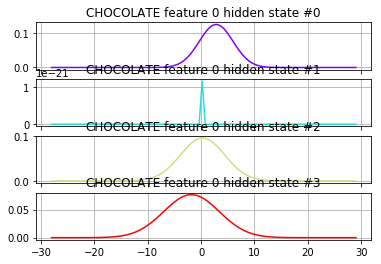

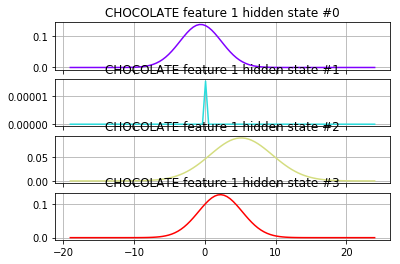

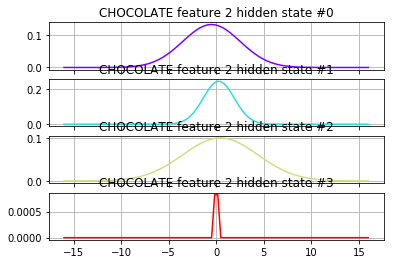

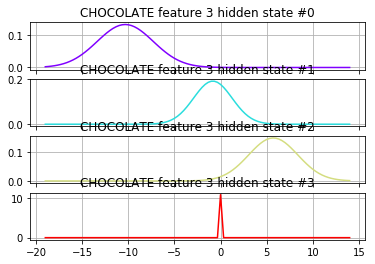

In [29]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
The `ModelSelector` class is designed to be a strategy pattern for choosing different model selectors.  

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

I trained each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [31]:
import math
import statistics
import warnings

import numpy as np
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import KFold


class ModelSelector(object):
    '''
    base class for model selection
    '''

    def __init__(self, all_word_sequences: dict, all_word_Xlengths: dict, this_word: str,
                 n_constant=3,
                 min_n_components=2, max_n_components=10,
                 random_state=14, verbose=False):
        self.words = all_word_sequences
        self.hwords = all_word_Xlengths
        self.sequences = all_word_sequences[this_word]
        self.X, self.lengths = all_word_Xlengths[this_word]
        self.this_word = this_word
        self.n_constant = n_constant
        self.min_n_components = min_n_components
        self.max_n_components = max_n_components
        self.random_state = random_state
        self.verbose = verbose

    def select(self):
        raise NotImplementedError

    def base_model(self, num_states):
        # with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=DeprecationWarning)
        # warnings.filterwarnings("ignore", category=RuntimeWarning)
        try:
            hmm_model = GaussianHMM(n_components=num_states, covariance_type="diag", n_iter=1000,
                                    random_state=self.random_state, verbose=False).fit(self.X, self.lengths)
            if self.verbose:
                print("model created for {} with {} states".format(self.this_word, num_states))
            return hmm_model
        except:
            if self.verbose:
                print("failure on {} with {} states".format(self.this_word, num_states))
            return None


class SelectorConstant(ModelSelector):
    """ select the model with value self.n_constant

    """

    def select(self):
        """ select based on n_constant value

        :return: GaussianHMM object
        """
        best_num_components = self.n_constant
        return self.base_model(best_num_components)


class SelectorBIC(ModelSelector):
    """ select the model with the lowest Baysian Information Criterion(BIC) score
    """
    def score(self, num_states):
        model = self.base_model(n)
        features = len(self.X)
        logL = model.score(self.X, self.lengths)
        logN = np.log(features)
        parameters = num_states ** 2 + 2 * num_states * n - 1
        d = model.n_features
        p = num_states ** 2 + 2 * d * num_states - 1
        return -2.0 * logL + p * logN, model

    def select(self):
        warnings.filterwarnings("ignore", category=DeprecationWarning)
        try:
            bics = []
            for num_states in range(self.min_n_components, self.max_n_components + 1):
                bics.append(score(num_states))
            best_model = max(bics)[1]
            return best_model
        except:
            return self.base_model(self.n_constant)


class SelectorDIC(ModelSelector):
    ''' select best model based on Discriminative Information Criterion
    '''
    def score(self):
        model = self.base_model(n)
        this_log = model.score(self.X, self.lengths) 
        rest_logs = [model.score(X, lengths) for word, (X, lengths) in self.hwords.items() if word != self.this_wor]
        return this_log - np.mean(rest_logs), model

    def select(self):
        try:
            dics = []
            for num_states in range(self.min_n_components, self.max_n_components + 1):
                dics.append(score(num_states))
            best_model = max(dics)[1]
            return best_model
        except:
            return self.base_model(self.n_constant)


class SelectorCV(ModelSelector):
    ''' select best model based on average log Likelihood of cross-validation folds
    '''
    def score(self, num_states):
        logLikelihoods = []
        split_method = KFold(n_splits=2)
        for cv_train_idx, cv_test_idx in split_method.split(self.sequences):
            self.X, self.lengths = combine_sequences(cv_train_idx, self.sequences)
            model = self.base_model(num_states)
            X, lengths = combine_sequences(cv_test_idx, self.sequences)
            logLikelihoods.append(model.score(X, lengths))
        self.X, self.lengths = self.hwords[self.this_word]
        return np.mean(logLikelihoods), model

    def select(self):
        warnings.filterwarnings("ignore", category=DeprecationWarning)
        try:
            avg_log_likelihood = []
            for num_states in range(self.min_n_components, self.max_n_components + 1):
                avg_log_likelihood.append(self.score(num_states))
            best_model = max(avg_log_likelihood)[1]
            return best_model
        except:
            return self.base_model(self.n_constant)
        

In [32]:

training = asl.build_training(features_ground)  # Experiment here with different feature sets 
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, I suspected that more complex models will have higher likelihoods. However, that doesn't tell which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, I ccompared scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored. In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. 

In [33]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:426: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


**Note:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process. I used these [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) that include the formula for my implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.


**Note:** As the `hmmlearn` library is not be able to train or score all models, I implemented try/except contructs as necessary to eliminate non-viable models from consideration.

In [34]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [35]:

training = asl.build_training(features_ground)  
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return_n_iter=True)


Training complete for FISH with 3 states with time 0.11446080600001096 seconds
Training complete for BOOK with 2 states with time 2.1850765030000048 seconds
Training complete for VEGETABLE with 3 states with time 0.48880823400000395 seconds
Training complete for FUTURE with 2 states with time 2.029971531000001 seconds
Training complete for JOHN with 9 states with time 23.57894649299999 seconds


In [36]:
#SelectorBIC module

training = asl.build_training(features_ground)  
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.02044832900000415 seconds
Training complete for BOOK with 3 states with time 0.08409940399999982 seconds
Training complete for VEGETABLE with 3 states with time 0.025243087999996305 seconds
Training complete for FUTURE with 3 states with time 0.05233885200001964 seconds
Training complete for JOHN with 3 states with time 0.6760925830000133 seconds


In [ ]:
# SelectorDIC  module
training = asl.build_training(features_ground)  # Experiment here with different feature sets 
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.021369717000027322 seconds
Training complete for BOOK with 3 states with time 0.07798045499998807 seconds
Training complete for VEGETABLE with 3 states with time 0.026317677000008644 seconds
Training complete for FUTURE with 3 states with time 0.05598618400000532 seconds
Training complete for JOHN with 3 states with time 0.7228162609999913 seconds


In [ ]:
CVTimes = [0.09670115914195776, 2.907256133854389, 0.6297865349333733, 2.8252335761208087, 32.937999906018376]
BicTimes = [0.02782643004320562, 0.10402497299946845, 0.030560943065211177, 0.08237440488301218, 0.7894107620231807]
DicTimes = [0.023151866858825088, 0.11232681502588093, 0.02939670509658754, 0.0784992128610611, 0.7862564688548446]
print("Avg CV Selector Speed", sum(CVTimes)/len(CVTimes))
print("Avg BIC Selector Speed", sum(BicTimes)/len(BicTimes))
print("Avg DIC Selector Speed", sum(DicTimes)/len(DicTimes))

Avg CV Selector Speed 7.879395462013781
Avg BIC Selector Speed 0.20683950260281564
Avg DIC Selector Speed 0.20592621373943984


In [ ]:
import pandas as pd
metric = pd.DataFrame()
metric['CV'] = CVTimes
metric['BIC'] = BicTimes
metric['DIC'] = DicTimes
metric['x'] = np.arange(0,5)

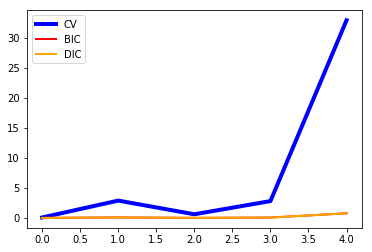

In [ ]:
from numpy import *
from scipy.stats import poisson
import numpy as np
import matplotlib.pyplot as plt
plt.plot( 'x', 'CV', data=metric, marker='',  markersize=12, color='blue', linewidth=4)
plt.plot( 'x', 'BIC', data=metric, marker='', color='red', linewidth=2)
plt.plot( 'x', 'DIC', data=metric, marker='', color='orange', linewidth=2)

plt.legend()

Text(0.5, 1.0, 'DIC')

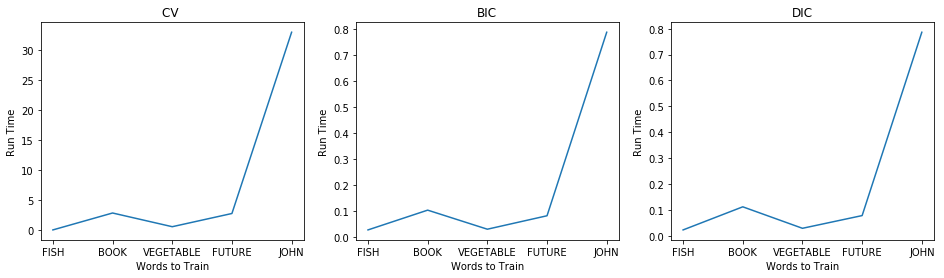

In [ ]:
params = words_to_train
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(16,4))
axes[0].set_xlabel("Words to Train")
axes[1].set_xlabel("Words to Train")
axes[2].set_xlabel("Words to Train")

axes[0].set_ylabel("Run Time")
axes[1].set_ylabel("Run Time")
axes[2].set_ylabel("Run Time")

axes[0].plot(params, CVTimes)
axes[0].set_title("CV ")
axes[1].plot(params, BicTimes)
axes[1].set_title("BIC")
axes[2].plot(params, DicTimes)
axes[2].set_title("DIC")

In [ ]:
metric

,CV,BIC,DIC,x
0,0.096701,0.027826,0.023152,0
1,2.907256,0.104025,0.112327,1
2,0.629787,0.030561,0.029397,2
3,2.825234,0.082374,0.078499,3
4,32.938000,0.789411,0.786256,4


When it come to speed SelectorCV is definatly the loser it is a whole magnitude high than the BIC Selector and DIC Selector times. The outcomes of the BIC Selector and DIC Selector are identical. However the DIC Selector is slightly faster than the BIC Selector. So DIC Seems to be the optimal selection algorithm.

##  Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, I experimented with the models and presented my results.  Instead of training only five specific words as in the previous section, I trained the entire set with a feature set and model selector strategy.  


In [ ]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

def train_all_words(features, model_selector):
    training = asl.build_training(features)  
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [ ]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


### Recognition

In [ ]:
def recognize(models: dict, test_set: SinglesData):
    """ Recognize test word sequences from word models set
   """
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    probabilities = []
    guesses = []
    for word_id, (X, lengths) in test_set.get_all_Xlengths().items():
        #import pdb; pdb.set_trace()
        word_prob = {}
        for model_key, model_value in models.items():
            try:
                score = model_value.score(X, lengths)
                word_prob[model_key] = score
            except:
                word_prob[model_key] = float("-inf")
        probabilities.append(word_prob)
        guesses.append(max(word_prob, key=word_prob.get))
    return probabilities, guesses
    
features_to_try = {"features_norm":features_norm, "features_polar":features_polar, "features_delta":features_delta, "features_custom":features_custom, "features_custom_2":features_custom_2, "features_delta_normal":features_delta_normal, "features_delta_normal_polar":features_delta_normal_polar, "features_delta_ground":features_delta_ground, "features_delta_normal_ground":features_delta_normal_ground, "features_custom_2_ground":features_custom_2_ground}
model_selectors_to_try = {"SelectorConstant":SelectorConstant, "SelectorCV":SelectorCV, "SelectorBIC":SelectorBIC, "SelectorDIC":SelectorDIC}
feature_models = [(features_to_try[features], model_selectors_to_try[model_selector], features, model_selector) for features in features_to_try.keys() for model_selector in model_selectors_to_try]

In [ ]:
for f, m, f_name, m_name in feature_models:
    print("---"*5)
    print("Running", m_name,"on", f_name)
    models = train_all_words(f, m)
    test_set = asl.build_test(f)
    probabilities, guesses = recognize(models, test_set)
    show_errors(guesses, test_set)

---------------
Running SelectorConstant on features_norm

**** WER = 0.6235955056179775
Total correct: 67 out of 178
Video  Recognized                                                    Correct
    2: *MARY WRITE *ARRIVE                                           JOHN WRITE HOMEWORK
    7: JOHN *NEW *JOHN CAN                                           JOHN CAN GO CAN
   12: *SHOULD *HAVE *GO1 CAN                                        JOHN CAN GO CAN
   21: *LIKE *NEW *HAVE *IX-1P *CAR *BLAME *CHICKEN *WRITE           JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *IX LIKE *LIKE *LIKE IX                                       JOHN LIKE IX IX IX
   28: *ANN LIKE *ANN *LIKE *ANN                                     JOHN LIKE IX IX IX
   30: *SHOOT LIKE *LOVE *LIKE *MARY                                 JOHN LIKE IX IX IX
   36: *LEAVE *NOT *YESTERDAY *VISIT LIKE *JOHN                      MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *LEAVE *FUTURE1 *VEGETABLE LOVE                          JO

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return_n_iter=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (6). Possibly due to duplicate

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return_n_iter=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return_n_iter=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return_n_iter=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicat

In [ ]:
# Recognize the test set and display the result with the show_errors method
models = train_all_words(features_delta_normal_polar, SelectorConstant)
test_set = asl.build_test(features_delta_normal_polar)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

In [ ]:
#  Recognize the test set and display the result with the show_errors method
models = train_all_words(features_delta_normal_polar, SelectorBIC)
test_set = asl.build_test(features_delta_normal_polar)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

In [ ]:
#  Recognize the test set and display the result with the show_errors method
models = train_all_words(features_delta_normal_polar, SelectorDIC)
test_set = asl.build_test(features_delta_normal_polar)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

I actually ran 30 test and it seems like Running SelectorConstant, SelectorBIC, andSelectorDIC on features_delta_normal_polar provided the best(lowest) WER. It seems like the feature space biggest effect on the WER. WER could be improved by better features. Using N-grams instead of 1-grams might prove to be fruitful.

# Future work
##  Improve the WER with Language Models

I've squeezed just about as much as I can out of the model and still only get about 50% of the words right! Surely I can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. In future, one can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer I implemented  is equivalent to a "0-gram" SLM. We can improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  


In [ ]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()